### 03 SHAP Explainability (Model Transparency)

This notebook applies SHAP to explain model predictions and identify key factors influencing depression risk.


Import Library

In [19]:
import xgboost as xgboost_lib
import shap
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Load test data + feature names

In [2]:
X_test = joblib.load("X_test_trans.joblib")
y_test = joblib.load("y_test.joblib")
feature_names = joblib.load("feature_names.joblib")

if hasattr(X_test, "toarray"):
    X_test = X_test.toarray()

X_test_df = pd.DataFrame(X_test, columns=feature_names)

print(X_test_df.shape)

(4347, 87)


### SHAP for MLP (Sigmoid)

Load MLP (sigmoid)

In [3]:
mlp_sigmoid = joblib.load("mlp_sigmoid_model.joblib")

Prepare background + sample data

In [4]:
background = shap.sample(X_test_df, 100, random_state=42)

X_test_sample = shap.sample(X_test_df, 300, random_state=42)

print("Background shape:", background.shape)
print("Sample shape:", X_test_sample.shape)


Background shape: (100, 87)
Sample shape: (300, 87)


SHAP explainer (MLP)

In [6]:
def mlp_predict_proba(X):
    return mlp_sigmoid.predict_proba(X)[:, 1]

explainer_mlp = shap.KernelExplainer(
    mlp_predict_proba,
    background
)

shap_values_mlp = explainer_mlp.shap_values(X_test_sample)

print("SHAP values shape (MLP):", np.array(shap_values_mlp).shape)

  0%|          | 0/300 [00:00<?, ?it/s]

SHAP values shape (MLP): (300, 87)


Global importance (MLP, bar)

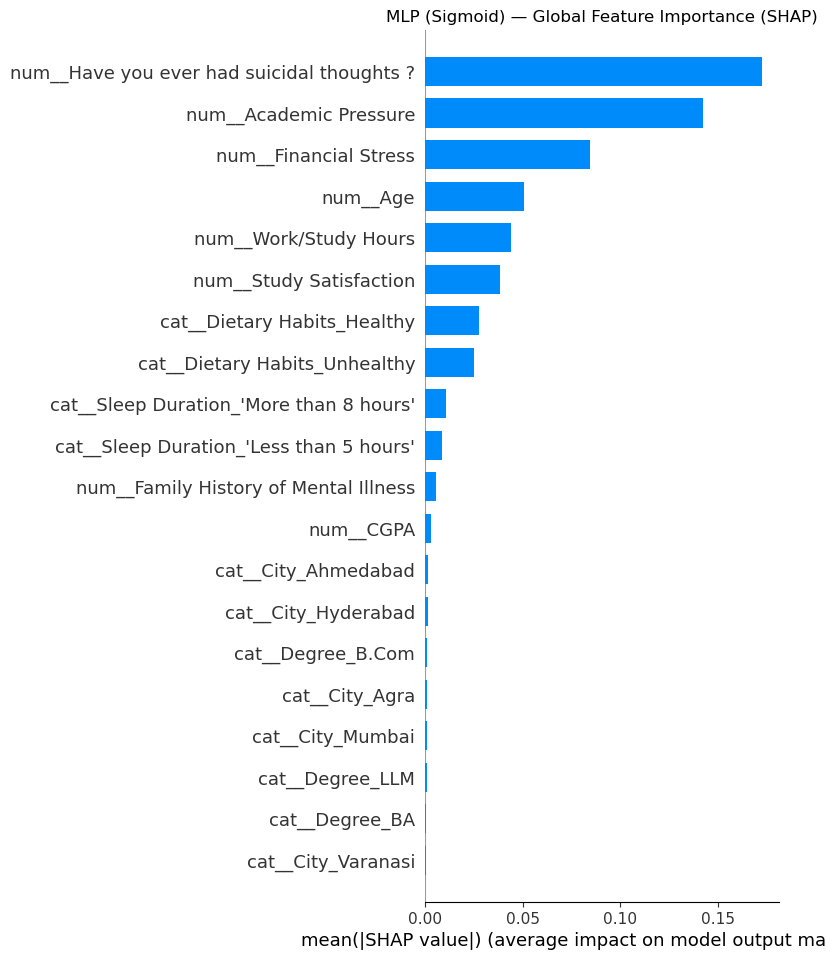

In [7]:
shap.summary_plot(
    shap_values_mlp,
    X_test_sample,
    plot_type="bar",
    show=False
)
plt.title("MLP (Sigmoid) — Global Feature Importance (SHAP)")
plt.show()

Beeswarm plot (MLP)

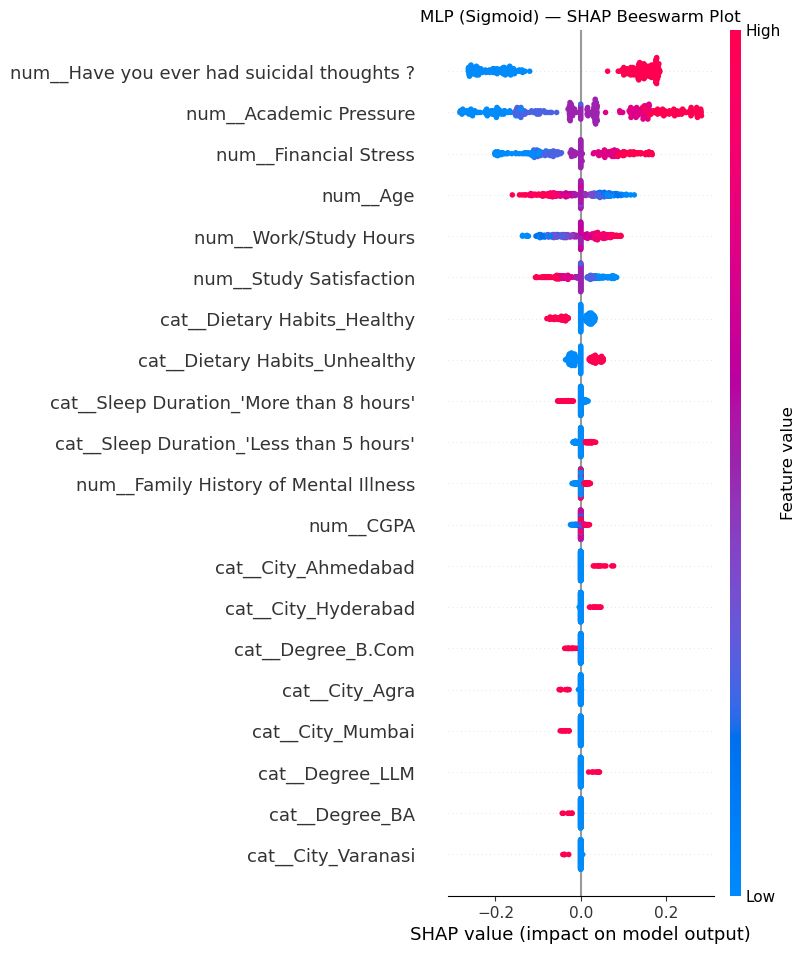

In [8]:
shap.summary_plot(
    shap_values_mlp,
    X_test_sample,
    show=False
)
plt.title("MLP (Sigmoid) — SHAP Beeswarm Plot")
plt.show()

Local importance (MLP)

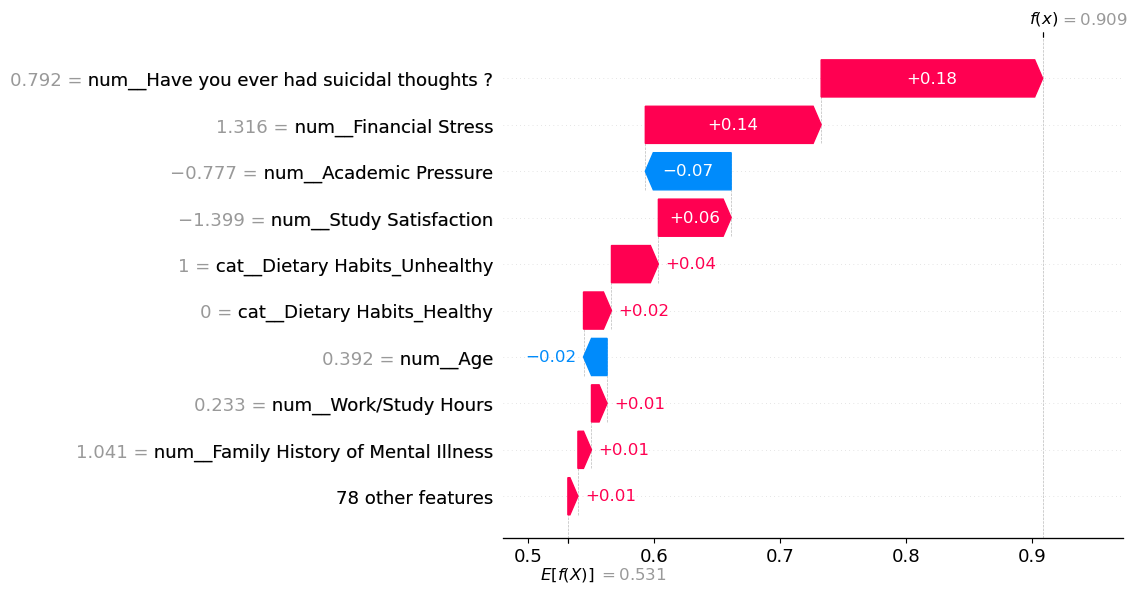

In [9]:
i = 0  # index within X_test_sample

shap.plots.waterfall(
    shap.Explanation(
        values=shap_values_mlp[i],
        base_values=explainer_mlp.expected_value,
        data=X_test_sample.iloc[i],
        feature_names=X_test_sample.columns
    )
)


### SHAP for XGBoost

Load XGBoost model

In [23]:
xgb_model = joblib.load("xgb_model.joblib")
type(xgb_model)

xgboost.sklearn.XGBClassifier

SHAP explainer (XGBoost)

In [24]:
dm_test = xgboost_lib.DMatrix(X_test_df, feature_names=X_test_df.columns.tolist())

contrib = xgb_model.get_booster().predict(dm_test, pred_contribs=True)

shap_values_xgb = contrib[:, :-1]
base_values_xgb = contrib[:, -1]

print("SHAP values shape:", shap_values_xgb.shape)

SHAP values shape: (4347, 87)


Global importance (XGBoost, bar)

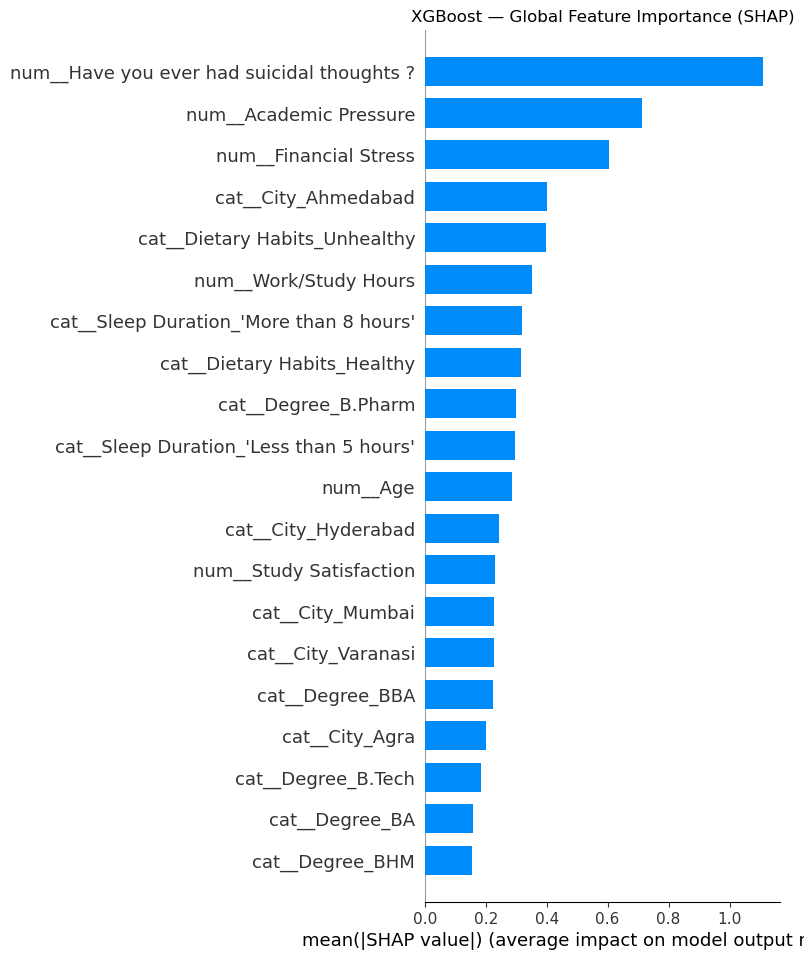

In [26]:
shap.summary_plot(shap_values_xgb, X_test_df, plot_type="bar", show=False)
plt.title("XGBoost — Global Feature Importance (SHAP)")
plt.show()

Beeswarm plot (XGBoost)

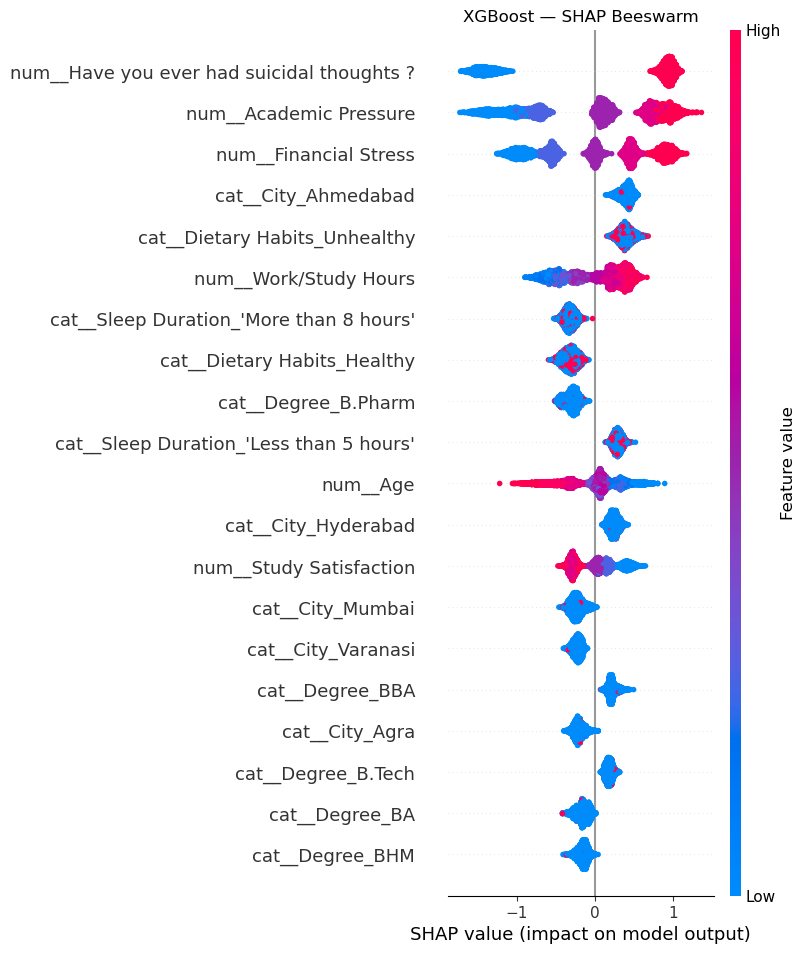

In [27]:
shap.summary_plot(shap_values_xgb, X_test_df, show=False)
plt.title("XGBoost — SHAP Beeswarm")
plt.show()

Local importance (XGBoost)

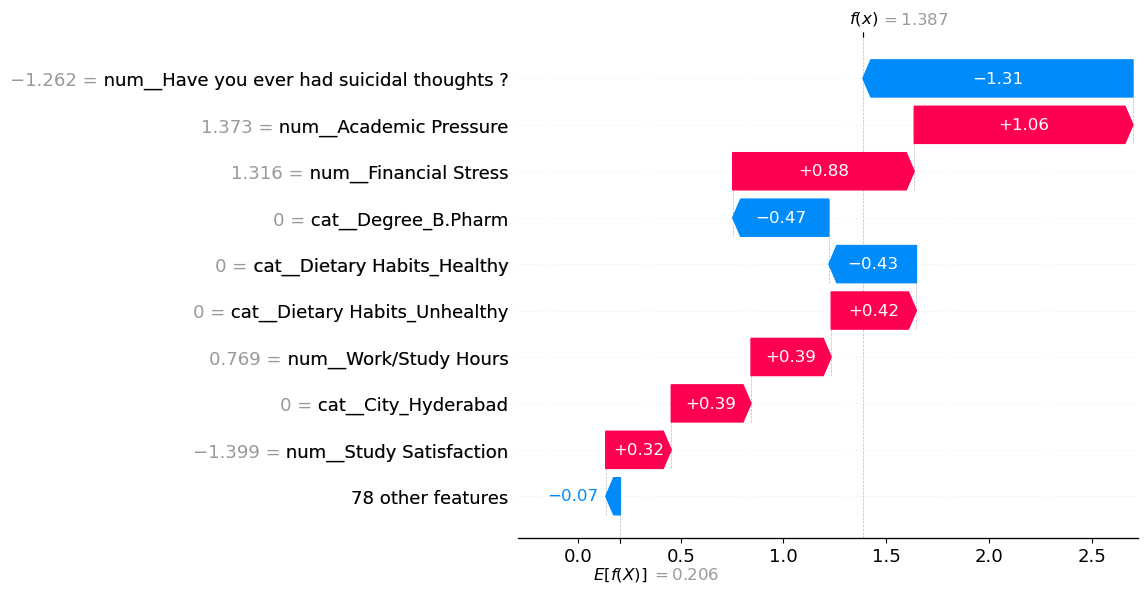

In [29]:
i = 0
exp = shap.Explanation(
    values=shap_values_xgb[i],
    base_values=base_values_xgb[i],
    data=X_test_df.iloc[i],
    feature_names=X_test_df.columns
)
shap.plots.waterfall(exp)